* Machine learning models can learn the statistical latent space of images, music, and stories, and they can then sample from this space.

* Examples
  * Language model: https://openai.com/blog/better-language-models/
  * Music generation: https://magenta.tensorflow.org/groovae
  * Style-based image generation: https://www.youtube.com/watch?v=kSLJriaOumA

* In this chapter, we will explore
  * Text generation with LSTM
  * Variational autoencoders
  * Generative adversarial networks

## 8.1 Text generation with LSTM

### How do you generate sequence data?


* Train a network to predict the next token or next few tokens in a sequence, using the previous tokens as input.

* When working with text data, tokens are typically words or characters, and any network that can model the probability of the next token given the previous ones is called a language model.

* A language model captures the latent space of language: its statistical structure.

* Once you have such a trained language model, you can sample from it.
  * You feed it an initial string of text (called conditioning data), ask it to generate the next character or the next word, add the generated output back to the input data, and repeat the process many times.
  
  <img src="https://drive.google.com/uc?id=1BuR76rTTrhrUTaYbcvynr_ag1M0_gCxn" width="800">
  
  

### The importance of the sampling strategy

* A naive approach is greedy sampling.
  * It always chooses the most likely next character.
  
* A more interesting approach is to introduce randomness in the sampling process.
  * This is called stochastic sampling.
  * We need a way to control the amount of randomness.
  * To do so, we will introduce a parameter called the softmax temperature that characterizes the entropy of the probability distribution used for sampling.
  
  ```python
  import numpy as np

  def reweight_distribution(original_distribution, temperature=0.5):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)
  ```
  
  <img src="https://drive.google.com/uc?id=1Bmgy-T_LAHsWn41Q2k1MAVsQJXg3ywKn" width="800">

### Character-level LSTM for text generation

In [ ]:
# preparing the data

from tensorflow.keras import utils
import numpy as np

path = utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('Corpus length:', len(text))

614400/600901 [==============================] - 1s 1us/step
Corpus length: 600893


In [ ]:
print(text[:300])

preface


supposing that truth is a woman--what then? is there not ground
for suspecting that all philosophers, in so far as they have been
dogmatists, have failed to understand women--that the terrible
seriousness and clumsy importunity with which they have usually paid
their addresses to truth, ha


* We will extract partially overlapping sequences of length `maxlen`, one-hot encode then, and pack them in a 3D Numpy array `x` of shape `(sequences, maxlen, unique_characters)`.

* Also, we will prepare an array `y` containing the corresponding targets: the one-hot-encoded characters that come after each extracted sequence.

In [ ]:
# Length of extracted character sequences 60개의 character가 인풋 그럼 y값은 그 다음값인 61번째가 되겠지?
maxlen = 60

# We sample a new sequence every `step` characters 전체 텍스트에서 얼마나 이동하면서 text를 짤라낼것인가에 대한 parameter
step = 3

# This holds our extracted sequences 자른 60개의 character를 instance 하나라고 생각한다면 그 instance들을 sentences라는데에 저장할 것이다.
sentences = []

# This holds the targets (the follow-up characters) 그 다음 chracter y값들의 하나하나를 여기에 저장.
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

# List of unique characters in the corpus 그리고 모든 character들을 검사하면서 character단위의 vocabulary를 만든다.
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool) # 위에서 정의한 x의 input을 의미하는대로 첫번째는 데이터 개수, 두번째는 데이터 길이 , 각각 단어에 해당되는 one-hot coding
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)         # y는 뭐 그냥 하나이니까 첫번째는 데이터 개수 두번째는 그 각각 하나에 대한 one-hot coding이다.
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1                           # 해당되는 단어의 index에대가 그냥 0을 1로 변환 그럼 [0,0,0,0,1,0,0,0 ...]이런 느낌이겠지?
    y[i, char_indices[next_chars[i]]] = 1                         # 전에 sequence의 분석할때는 [0,0,0,0,1,0,0,0 ...]가 아닌 5이런느낌이였는데 차이가 뭐임

Number of sequences: 200278
Unique characters: 57
Vectorization...


* Building the network

In [ ]:
from tensorflow.keras import layers, models, optimizers

model = models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


* Training the language model and sampling from it

In [ ]:
# sample the next character given the model's predictions
def sample(preds, temperature=1.0):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature       #softmax가 들어가기 전의 값을 로직? 이라고 부르는데 그 값에대가 log를 씌우고 temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

In [ ]:
import random                                                           # 이거는 나중에 시간이 좀 많이 남으면 보는걸로 하고 그냥 개념은 아니까 넘어가자 ㅠ
import sys

for epoch in range(1, 20):
  print('epoch', epoch)
  model.fit(x, y, batch_size=128, epochs=1) 
  
  if epoch == 1 or epoch == 19:                                         # 모델이 어떤 캐릭터를 생성하는가 보기 위한 코드 
    start_index = random.randint(0, len(text)-maxlen-1)                 # 첫번째 epoch이 끝나면 random한 integer를 하나 만들어서 원래 데이터의 어디 index를 랜덤값으로 아무거나 가져온다
    generated_text = text[start_index: start_index+maxlen]              # 그리고 그것을 입력값으로 가져오고.
    print('--- Generating with seed: "' + generated_text + '"')
    
    for temperature in [0.2, 0.5, 1.0, 1.2]:                            # temperature에 따라 그 결과값을 본다.
      print('------ temperature: ', temperature)
      sys.stdout.write(generated_text)
      
      # generate 400 characters
      for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
          sampled[0, t, char_indices[char]] = 1.
          
        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]
        
        generated_text += next_char
        generated_text = generated_text[1:]
        
        sys.stdout.write(next_char)
        sys.stdout.flush()
      print()

epoch 1
1565/1565 [==============================] - 31s 17ms/step - loss: 1.9455
--- Generating with seed: "he first of europeans
according to my taste, the hohenstaufe"
------ temperature:  0.2
he first of europeans
according to my taste, the hohenstauferent and strong the self-consequently and the self-conscious and the says and in the man and the has a deren the says and the has of the says a part of the can the supposing the self-conscience, and supposion of the self-constant in the case the self-constance of the self the selves of the self-constrest and the supposion and the has the self-constant and the strong the more and the says and the s
------ temperature:  0.5
self-constant and the strong the more and the says and the selves and be alvose of the "many sunsequent of the good and the has the his pare who has more and look good the hoven and hempe are we have more the love formelone. the in has a condence of the sans it is that the has a diston the camplessive, the extration 

## 8.2 Generating images with variational autoencoders

* *\"What I cannot create, I do not understand\"* - Richard Feynman

* Sampling from a latent space of images to create entirely new images or edit existing ones
  * The techniques are not specific to images.


>### Sampling from latent spaces of images

* The key idea
  * Develop a low-dimensional latent space of representations where any point can be mapped to a realistic-looking image.
  
* Generator or decoder
  * The module takes as input a latent point and outputs an image.
  
   <img src="https://drive.google.com/uc?id=17u5Er8I1qqB3laoHhM6k3V-U3HaSIlBs" width="800">
  
* Two popular approaches: variational autoencoders (VAEs) and generative adversarial networks (GANs)

  <img src="https://drive.google.com/uc?id=17y_hX8vKsfsQuFqHikncuiij8gxdquf8" width="800">
  
* The concept vector
  * The idea of a concept vector is very similar to that of word embeddings.
  * Given a latent space of representations, or an embedding space, certain directions in the space may encode interesting axes of variation in the original data.
  
   <img src="https://drive.google.com/uc?id=17wqcRl5q6ChI0jvEUDZgjIYLkQ8MFLve" width="800">
  

>### Variational autoencoders

* Autoencoders with Bayesian inference

* A classical autoencoder takes an input, maps it to a latent vector space via an encoder module, and then decodes it back to an output with the same dimensions as the input via a decoder module.

  <img src="https://drive.google.com/uc?id=17xJz97hv18a3PrId5yD6_0XNaIMHcfZ0" width="800">

* A VAE turns the image into the parameters of a statistical distribution, a mean and a variance, instead of compressing its input image into a fixed code in the latent space.
  * The VAE then uses the mean and variance parameters to randomly sample one element of the distribution, and decodes that element back to the original input.
  
  <img src="https://drive.google.com/uc?id=17zJB7PMYqIfEtVmF6skwRuTCTlJnI0c0" width="800">
  
* How a VAE works:
  * An encoder module turns the input samples `input_img` into two parameters in a latent space of representations, `z_mean` and `z_log_variance`.
  * You randomly sample a point `z` from the latent normal distribution that's assumed to generate the input image, via `z = z_mean + exp(z_log_variance) * epsilon` where `epsilon` is a random tensor of small values.
  * A decoder module maps this point in the latent space back to the original input image.
  
* Because `epsilon` is random, the process forces the latent space to be continuously meaningful.

* The VAE is trained via two loss functions:
  * a reconstruction loss that forces the decoded samples to match the initial inputs
  * a regularization loss that helps learn well-formed latent spaces and reduce overfitting to the training data
  
* How it can be implemented:

  ```python
  z_mean, z_log_variance = encoder(input_img)

  z = z_mean + exp(z_log_variance) * epsilon

  reconstructed_img = decoder(z)

  model = Model(input_img, reconstructed_img)
  ```

In [ ]:
# Create a sampling layer

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Input, Model

class Sampling(layers.Layer):                                                    # encoder가 뱉어주는 확률분포로부터 sampling을 하는 그러한 layer층을 만들어준다
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder network

latent_dim = 2

encoder_inputs = Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [ ]:
# Decoder network

latent_inputs = Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x) ##Conv2DTranspose라는 녀석이 있는데 convolution의 반대 작용을 하는 애다 라고 이해해야한다 일단.
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x) # 원래 stride=2라는 의미는 resolution이 절반으로 준다는것이지만
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x) #conv2D에서 resolution=2라는건 resolution이 두배로 증가~
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [ ]:
# Define VAE as a model with a custom train_step
from tensorflow.keras import losses, optimizers

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)                                # 여기서 데이터가 encoder에 들어가서 평균과 분산 그리고 거기서부터 sampling된 z를 뱉어낸다. 3개가나온다
            reconstruction = decoder(z)                                         # 이 z가 decoder에 들어가서 28*28*1의 output이 나올것이다.
            reconstruction_loss = tf.reduce_mean(                               # 그럼 input과 output이 나왔으니 그걸로 reconstruction loss에 대해서 계산을 해본다.
                losses.binary_crossentropy(data, reconstruction)                
            )
            reconstruction_loss *= 28 * 28                                      # 여기서는 정의된 분포가 표준정규분포이다. 그러니 이 분포와 유사해야한다는 loss를 계산값으로 넣은것이다.
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)     # 이게 왜 이렇게 계산되는 알려면 밑에 정의 되어있는 kl divergence측도에 대해서 알아야하는데 나중에 다루자...
            kl_loss = tf.reduce_mean(kl_loss)                                   # 컨셉만 이해하자면 두 벡터의 유사도를 측정하는것인데 두 벡터의 유사도를 측정하는 측도로 거리로 측정하는경우가 많은데
            kl_loss *= -0.5                                                     # 벡터들의 거리를 측정하는건 되게 많다 코사인 distance, 유클라디안 distance, manhattan distance요런거 
            total_loss = reconstruction_loss + kl_loss                          # 
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

kl_loss에 대해서 좀 알아보자<br>
kl_loss는 위에서 말한 regularization loss 부분인데 정의된 분포와 유사해야한다는 loss를 계산값으로 넣은것이다<br>
이렇게 유사해야한다는 loss에 대한 계산을 하려면 일단 유사도에 대한 것부터 알고 넘어가야한다<br>
* 유사도라는것은 어떻게 측정할까??<br>
 * 두 벡터를 기준으로 유사도를 측정하자면 보통 거리로 특정한다<br>
 ex) 코사인 distance, 유클라디안 distance, 맨하탄 distance ....<br>
 * 즉 어떤 두 객체사이의 거리를 잰다는건 결국 그 객체사이의 유사도를 잰다는것과 똑같은 의미이다.
* 이러한 컨셉을 이제 분포에 적용시키는 것이다.
 * 임의의 분포사이에 비슷한 정도를 추정하는 측도가 하나 있다. <br>
 ==> 그것이 바로 이 kullback-leibler divergence이다.
* kullback-Leibler divergence
 * 아래의 Q와 P는 각각의 distribution이다. 통계학시간에 배운 확률변수라고 생각하면 된다.
 * 정확하게는 모르지만 그냥 분포의 거리를 측정하는 측도다~ 라고 생각하면 된다.
 * Q가 P를 잘 근사화시켜야 하는데 그것에 대한 loss가 kl_loss다~


* The Kullback-Leibler divergence `KL(Q|P)`
  * The KL divergence tells us how well the probability distribution `Q` approximates the probability distribution `P`.
  * It measures the similarity (or dissimilarity) between two probability distributions.
  * In VAEs, we assume that `P` is Gaussian with zero mean and unit variance.

In [ ]:
# Training the VAE

from tensorflow.keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 17s 18ms/step - loss: 213.7710 - reconstruction_loss: 211.5260 - kl_loss: 2.2451
Epoch 2/30
547/547 [==============================] - 10s 18ms/step - loss: 187.3508 - reconstruction_loss: 184.9147 - kl_loss: 2.4360
Epoch 3/30
547/547 [==============================] - 10s 18ms/step - loss: 182.8581 - reconstruction_loss: 180.5229 - kl_loss: 2.3352
Epoch 4/30
547/547 [==============================] - 10s 18ms/step - loss: 179.8299 - reconstruction_loss: 177.4668 - kl_loss: 2.3631
Epoch 5/30
547/547 [==============================] - 10s 18ms/step - loss: 176.7174 - reconstruction_loss: 174.2654 - kl_loss: 2.4519
Epoch 6/30
547/547 [==============================] - 10s 18ms/step - loss: 174.3335 - reconstruction_loss: 171.8395 - kl_loss: 2.4939
Epoch 7/30
547/547 [==============================] - 10s 18ms/step - loss: 172.8270 - reconstruction_loss: 170.2829 - kl_los

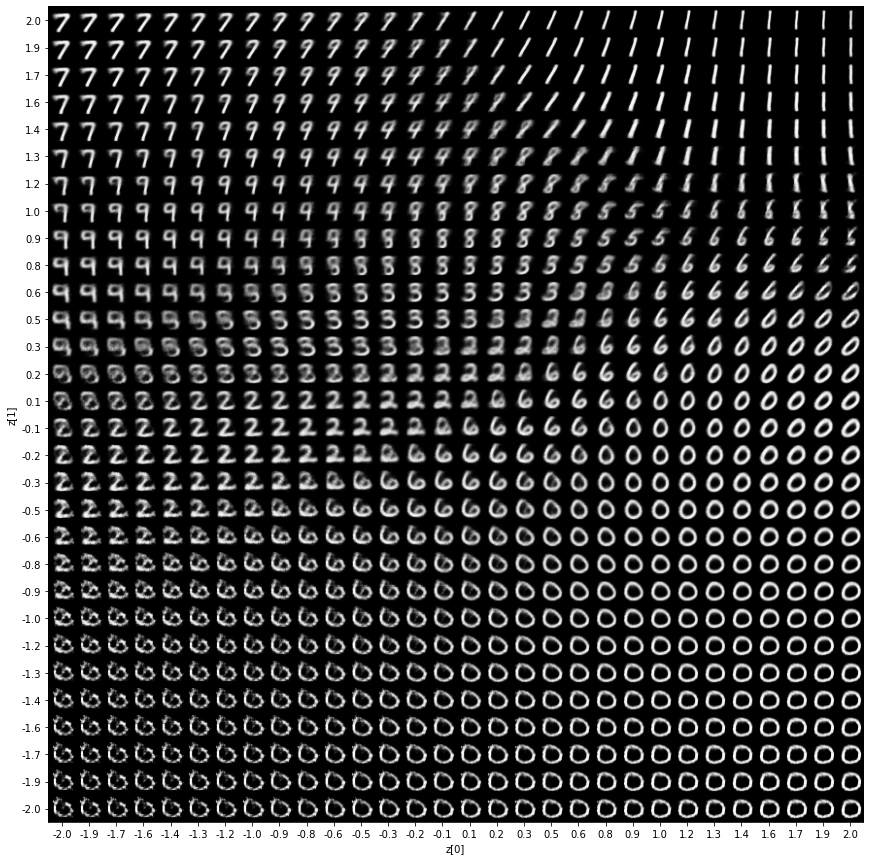

In [ ]:
import matplotlib.pyplot as plt

def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

여기에 이거를 잘 생각해보자 가지고 있는 데이터를 표준정규분포로 근사하도록 encoding가 맵핑을 시켰을것이다. 이 분포로부터 아무 벡터를 샘플링을 할것이다. 그리고 그 벡터를 decoder한테 넘겨서 막 생성을 할 것이다. 거의 무한대로 생성할 수 있다. 계속 sampling 하면서 decoder로 넘겨주면 decoder가 이미지를 생성할것이다. 실제로 우리가 mnist data를 가지고 학습한 모델이 잘 생성을 하는지 살펴보자. 이거 진짜 무슨 소리인지 ㅈㄹ 모르겠네 ㅋㅋ

## 8.3 Introduction to generative adversarial networks

* Generative adversarial networks (GANs) introduced in 2014 by Goodfellow et al.
  * an alternative to VAEs for learning latent spaces of images
  
* GAN consists of two parts:
  * Generator network : takes as input a random vector (a random point in the latent space), and decodes it into a synthetic image.
  * Discriminator network : takes as input an image (real or synthetic), and predicts whether the image came from the training set (real) or was created by the generator network (fake).
  
* The generator network is trained to be able to fool the discriminator network, at the same time the discriminator network is trained to distinguish between real or fake.

  <img src="https://drive.google.com/uc?id=17l0HmcJ7BaQ0F81HIj2Fe6bOaFeZtEVr" width="800">

* GAN is a system where the optimization minimum isn't fixed.
  * It's a dynamic system where the optimization process is seeking not a minimum, but an equilibrium between two forces.
  * For this reason, GANs are difficult to train.

> ### Schematic GAN implementation

* Deep convolutional GAN (DCGAN)
  * a GAN where the generator and discriminator are deep convnets.
  
* We will train the GAN on "flog" images from CIFAR10.
  * a dataset of 50,000 32\*32 RGB images belonging to 10 classes.
  
* Schematically, the GAN looks like:
  * A `generator` maps vectors of shape `(latent_dim,)` to images of shape `(32,32,3)`.
  * A `discriminator` maps images of shape `(32,32,3)` to a binary score estimating the probability that the image is real.
  * A `gan` network chains the generator and the discriminator together.
    * `gan(x) = discriminator(generator(x))`
  * We train the discriminator using examples of real and fake images along with "real"/"fake" labels.
  * To train the generator, we use the gradients of the generator's weights with regard to the loss of the `gan` model.
    * To be specific, we move the weights of the generator in a direction that makes the discriminator more likely to classify as "real" the images decoded by the generator.

> ### The generator

* A `generator` model that turns a (random) vector into a candidate image.

In [ ]:
from tensorflow.keras import layers, Input, models, optimizers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_3 (Dense)             (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 32, 32, 256)      104883

> ### The discriminator

* A `discriminator` model that takes as input a candidate image (real or synthetic) and classifies it into one of two classes: "generated image" or "real image from the training set".

In [ ]:
discriminator_input = Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer - important trick!
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6, 6, 128)         0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


> ### The adversarial network

* Training `gan` will update the weights of `generator` in a way that makes `discriminator` more likely to predict "real" when looking at fake images.

* Very important to note that you set the discriminator to be frozen during training `gan`!

In [ ]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input, gan_output)

gan_optimizer = optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


> ### How to train DCGAN

1.   Draw random points in the latent space (random noise).
2.   Generate images with `generator` using this random noise.
3.   Mix the generated images with real ones.
4.   Train `discriminator` using these mixed images, with corresponding targets.
5.   Draw new random points in the latent space.
6.   Train `gan` using these random vectors, with targets that all say "these are real images."

In [ ]:
import os
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = '/content'

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    
    # Add random noise to the labels -- trick
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

    from tensorflow.keras.losses import BinaryCrossentropy

    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))
        print(BinaryCrossentropy()(misleading_targets, gan(random_latent_vectors, training=False)))    
    
        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

170508288/170498071 [==============================] - 11s 0us/step
discriminator loss at step 0: 0.7023252844810486
adversarial loss at step 0: 0.7217410206794739
tf.Tensor(0.00013178594, shape=(), dtype=float32)
discriminator loss at step 100: 0.8729777336120605
adversarial loss at step 100: 4.103604316711426
tf.Tensor(2.766937, shape=(), dtype=float32)
discriminator loss at step 200: 0.6984066367149353
adversarial loss at step 200: 1.238060712814331
tf.Tensor(0.67225367, shape=(), dtype=float32)
discriminator loss at step 300: 0.6976776123046875
adversarial loss at step 300: 0.7308441400527954
tf.Tensor(0.6869576, shape=(), dtype=float32)
discriminator loss at step 400: 0.7136810421943665
adversarial loss at step 400: 0.7486231327056885
tf.Tensor(0.71764916, shape=(), dtype=float32)
discriminator loss at step 500: 0.7048465013504028
adversarial loss at step 500: 0.7929753065109253
tf.Tensor(0.75105894, shape=(), dtype=float32)
discriminator loss at step 600: 0.6885236501693726
adver

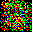

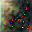

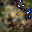

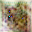

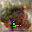

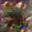

In [ ]:
from IPython.display import Image, display

display(Image('generated_frog0.png', width=128, height=128))
display(Image('generated_frog2000.png', width=128, height=128))
display(Image('generated_frog4000.png', width=128, height=128))
display(Image('generated_frog6000.png', width=128, height=128))
display(Image('generated_frog8000.png', width=128, height=128))
display(Image('generated_frog9900.png', width=128, height=128))

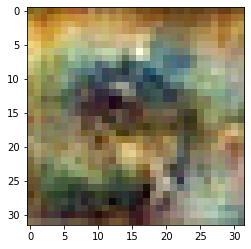

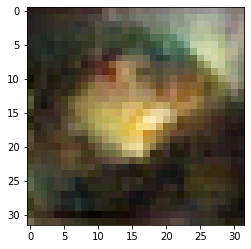

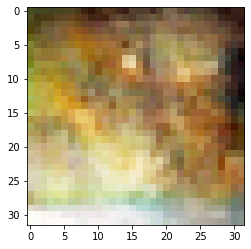

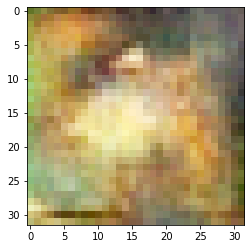

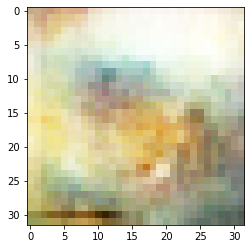

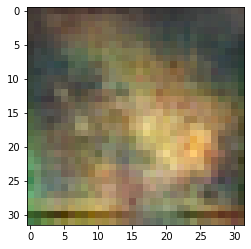

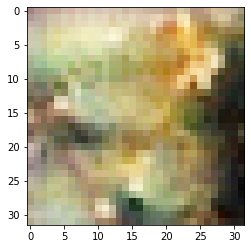

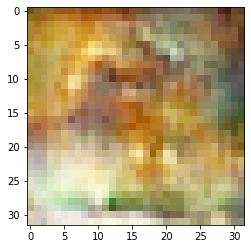

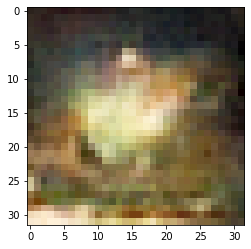

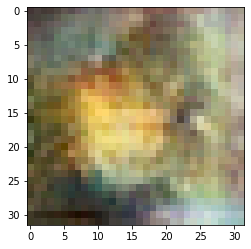

In [ ]:
import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=True)
    plt.figure()
    plt.imshow(img)
    
plt.show()
plt.close()


   <img src="https://drive.google.com/uc?id=17zjzuV5yA-mffuW--XwhXkj-UVxygMvH" width="800">